In [1]:
#!pip install category_encoders
#!pip install xgboost

In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
warnings.filterwarnings('ignore')

In [73]:
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier, XGBRegressor
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [5]:
#google drive 사용을 위한 함수 정의
def g_drive(url):
    url = url
    path = "https://drive.google.com/uc?id=" + url.split('/')[-2]
    df = pd.read_csv(path)
    return df

In [6]:
df = g_drive('https://drive.google.com/file/d/1dwDoU7JR_V2I5uwdE59aHNoP1NWsoTHW/view?usp=sharing')
test = g_drive('https://drive.google.com/file/d/1_P7_MF0cS3Ci7oDD7O6QOKOqK8AU66wT/view?usp=sharing')

In [7]:
df.head(10)

PassengerId HomePlanet CryoSleep  Cabin    Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P    TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S    TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S    TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S    TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S    TRAPPIST-1e  16.0  False   
5     0005_01      Earth     False  F/0/P  PSO J318.5-22  44.0  False   
6     0006_01      Earth     False  F/2/S    TRAPPIST-1e  26.0  False   
7     0006_02      Earth      True  G/0/S    TRAPPIST-1e  28.0  False   
8     0007_01      Earth     False  F/3/S    TRAPPIST-1e  35.0  False   
9     0008_01     Europa      True  B/1/P    55 Cancri e  14.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck                Name  \
0          0.0        0.0           0.0     0.0     0.0     Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0        Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0       Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0        Solam Susent   
4        303.0       70.0         151.0   565.0     2.0   Willy Santantines   
5          0.0      483.0           0.0   291.0     0.0   Sandie Hinetthews   
6         42.0     1539.0           3.0     0.0     0.0  Billex Jacostaffey   
7          0.0        0.0           0.0     0.0     NaN  Candra Jacostaffey   
8          0.0      785.0          17.0   216.0     0.0       Andona Beston   
9          0.0        0.0           0.0     0.0     0.0      Erraiam Flatic   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
5         True  
6         True  
7         True  
8         True  
9         True

In [8]:
#타겟 feature의 분포
transported = df['Transported'].value_counts()
transported

True     4378
False    4315
Name: Transported, dtype: int64

<AxesSubplot:ylabel='Transported'>

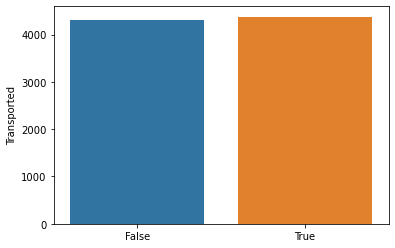

In [9]:
sns.barplot(x = transported.index, y = transported)

In [14]:
#정규표현식을 통해 PassengerId 데이터의 언더바와 언더바 뒤 숫자를 제거
import re
df['PassengerId'] = df['PassengerId'].str.replace(r'_[0-9]+', '')
test['PassengerId'] = test['PassengerId'].str.replace(r'_[0-9]+', '')

In [15]:
df

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0           0001     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1           0002      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2           0003     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3           0003     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4           0004      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688        9276     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689        9278      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690        9279      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691        9280     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692        9280     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0             0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1           109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2            43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3             0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4           303.0       70.0         151.0   565.0     2.0  Willy Santantines   
...           ...        ...           ...     ...     ...                ...   
8688          0.0     6819.0           0.0  1643.0    74.0  Gravior Noxnuther   
8689          0.0        0.0           0.0     0.0     0.0    Kurta Mondalley   
8690          0.0        0.0        1872.0     1.0     0.0       Fayey Connon   
8691          0.0     1049.0           0.0   353.0  3235.0   Celeon Hontichre   
8692        126.0     4688.0           0.0     0.0    12.0   Propsh Hontichre   

      Transported  
0           False  
1            True  
2           False  
3           False  
4            True  
...           ...  
8688        False  
8689        False  
8690         True  
8691        False  
8692         True  

[8693 rows x 14 columns]

In [16]:
df['PassengerId'].nunique()

6217

In [17]:
# PassengerId가 같으면 같은 그룹을 묶어줌, Group feature 생성
def groupcol(df):

    group = []
    tmp = 1

    for i in range(len(df)):
        if i == 0:
           group.append(tmp)
    
        else:
            if df['PassengerId'][i] != df['PassengerId'][i - 1]:
                tmp += 1
                group.append(tmp)
            
            elif df['PassengerId'][i] == df['PassengerId'][i - 1]:
                group.append(tmp)
                
    df['Group'] = group

In [18]:
groupcol(df)
groupcol(test)

In [19]:
df['Group'].nunique()

6217

In [20]:
# Cabin feature를 Deck, Num, Side 세 feature들로 나눠줌
def split_cabin(df):
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand = True)

In [21]:
split_cabin(df)
split_cabin(test)

In [22]:
df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0        0001     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1        0002      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2        0003     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3        0003     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4        0004      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  Group Deck Num Side  
0        False      1    B   0    P  
1         True      2    F   0    S  
2        False      3    A   0    S  
3        False      3    A   0    S  
4         True      4    F   1    S

In [23]:
def facility(df):
    df['Facilities pay'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

In [24]:
facility(df)
facility(test)

In [25]:
df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0        0001     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1        0002      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2        0003     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3        0003     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4        0004      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  Group Deck Num Side  Facilities pay  
0        False      1    B   0    P             0.0  
1         True      2    F   0    S           736.0  
2        False      3    A   0    S         10383.0  
3        False      3    A   0    S          5176.0  
4         True      4    F   1    S          1091.0

In [26]:
# feature들의 종류를 unique 값의 개수를 통해 구분해서 출력해줌
target = 'Transported'
features = [col for col in df.columns if col != target]

df_f = pd.concat([df[features], test], axis = 0)
text = ['Name', 'Cabin', 'PassengerId']
category = [col for col in features
            if df_f[col].nunique() < 25 and col not in text]
continuos = [col for col in features 
             if df_f[col].nunique() >= 25 and col not in text]

print(f'Total number of features : {len(features)}')
print(f'Number of categorical features : {len(category)}')
print(f'Number of continuos features : {len(continuos)}')
print(f'Number of text features : {len(text)}')

Total number of features : 18
Number of categorical features : 6
Number of continuos features : 9
Number of text features : 3


In [27]:
df.isnull().sum()

PassengerId         0
HomePlanet        201
CryoSleep         217
Cabin             199
Destination       182
Age               179
VIP               203
RoomService       181
FoodCourt         183
ShoppingMall      208
Spa               183
VRDeck            188
Name              200
Transported         0
Group               0
Deck              199
Num               199
Side              199
Facilities pay    908
dtype: int64

In [28]:
# 12세 이하 어린이와 동면상태인 승객은 편의시설 금액이 0이기 때문에, 조건에 맞는 승객의 데이터를 0으로 채워줌
def age_pay(df):
    
    columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Facilities pay']
    
    for i in range(len(df)):
        for col in columns:
            if df['Age'][i] <= 12:
                df[col][i] = 0
                
            if df['CryoSleep'][i] == True:
                df[col][i] = 0

In [29]:
age_pay(df)
age_pay(test)

In [30]:
df.isnull().sum()

PassengerId         0
HomePlanet        201
CryoSleep         217
Cabin             199
Destination       182
Age               179
VIP               203
RoomService       107
FoodCourt         106
ShoppingMall      103
Spa               114
VRDeck            107
Name              200
Transported         0
Group               0
Deck              199
Num               199
Side              199
Facilities pay    518
dtype: int64

In [31]:
# imputer를 통해 결측치를 채워주는 함수 정의
def impute(df, imputer_cols, strategy):
    imputer_cols = imputer_cols
    imputer = SimpleImputer(strategy = strategy)
    imputer.fit(df[imputer_cols])
    df[imputer_cols] = imputer.transform(df[imputer_cols])
    df[imputer_cols] = imputer.transform(df[imputer_cols])

In [32]:
impute(df, continuos, 'median')
impute(test, continuos, 'median')

In [33]:
df.isnull().sum()

PassengerId         0
HomePlanet        201
CryoSleep         217
Cabin             199
Destination       182
Age                 0
VIP               203
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              200
Transported         0
Group               0
Deck              199
Num                 0
Side              199
Facilities pay      0
dtype: int64

In [34]:
# Group이 같으면 가족이고, 가족은 HomePlanet과 Destination이 같음. 이를 통해 결측치를 가족들과 같게 채워준다.
def deal_na(df):

    columns = ['HomePlanet', 'Destination']
    df.sort_values(by = 'PassengerId', ascending = False)
    df.reset_index(drop = True, inplace = True)
    
    for col in columns:
        for i in range(1, len(df)):
            if df['Group'][i] == df['Group'][i - 1]:
                if (df.isnull()[col][i] == True) & (df.isnull()[col][i - 1] == False):
                    df[col][i] = df[col][i - 1]
        
                elif (df.isnull()[col][i] == False) & (df.isnull()[col][i - 1] == True):
                    df[col][i - 1] = df[col][i]
        
                else:
                    pass
        

In [35]:
deal_na(df)
deal_na(test)

In [36]:
df.isnull().sum()

PassengerId         0
HomePlanet        111
CryoSleep         217
Cabin             199
Destination       103
Age                 0
VIP               203
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              200
Transported         0
Group               0
Deck              199
Num                 0
Side              199
Facilities pay      0
dtype: int64

In [37]:
# 텍스트형 feature들을 drop
df.drop(text, axis = 1, inplace = True)
test.drop(text, axis = 1, inplace = True)

In [39]:
# imputer를 통해 나머지 결측치 처리
impute(df, category, 'most_frequent')
impute(test, category, 'most_frequent')

In [40]:
df.isnull().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Group             0
Deck              0
Num               0
Side              0
Facilities pay    0
dtype: int64

In [41]:
df.corr().sort_values(by = 'Transported', ascending = False)['Transported']

Transported       1.000000
FoodCourt         0.045583
Group             0.021825
ShoppingMall      0.009391
Num              -0.044502
Age              -0.074233
Facilities pay   -0.193514
VRDeck           -0.204874
Spa              -0.218545
RoomService      -0.241124
Name: Transported, dtype: float64

In [42]:
# 데이터를 훈련, 검증세트로 분할
train, val = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 2)

In [43]:
target = 'Transported'
features = [col for col in df.columns if col != target]

X_train = train[features]
X_val = val[features]

y_train = train[target]
y_val = val[target]

In [82]:
# 베이스라인 모델은 로지스틱회귀로 결정
def baseline(X_train, y_train):
    
    pipeline = make_pipeline(
        OrdinalEncoder(),
        LogisticRegression(random_state = 2)
    )
    
    dists = {
        'logisticregression__class_weight' : [None, 'Balanced']
    }
    
    clf = RandomizedSearchCV(
        pipeline,
        n_iter = 10,
        param_distributions = dists,
        cv = 5,
        scoring = 'roc_auc',
        random_state = 2,
        n_jobs = -1
    )
    
    clf.fit(X_train, y_train)
    
    return clf

In [83]:
# 베이스라인 모델에 fit, 스코어 출력
baseline = baseline(X_train, y_train)

In [84]:
baseline.best_score_

0.8309051374111007

In [85]:
baseline.best_params_

{'logisticregression__class_weight': None}

In [86]:
baseline.score(X_val, y_val)

0.8285978671842271

In [44]:
# 실제 모델은 XGBClassifier, RandomizedSearchCV를 통해 하이퍼 파라미터 튜닝
def fit_trees(X_train, y_train):

    pipeline = make_pipeline(
        OrdinalEncoder(),
        XGBClassifier(n_estimators = 102, random_state = 2)
    )
    
    dists = {
        'xgbclassifier__learning_rate' : uniform(0.05, 0.4),
        'xgbclassifier__max_depth' : randint(2, 5)
    }
    
    clf = RandomizedSearchCV(
        pipeline,
        param_distributions = dists,
        n_iter = 100,
        cv = 5,
        scoring = 'roc_auc',
        random_state = 2,
        n_jobs = -1
    )
    
    clf.fit(X_train, y_train)
    
    return clf

In [45]:
# 모델 fit, 베스트 파라미터와 스코어를 출력
clf = fit_trees(X_train, y_train)

In [46]:
clf.best_score_

0.8986136968848017

In [47]:
clf.best_params_

{'xgbclassifier__learning_rate': 0.1351069480486215,
 'xgbclassifier__max_depth': 4}

In [48]:
clf.score(X_val, y_val)

0.9023873537069738

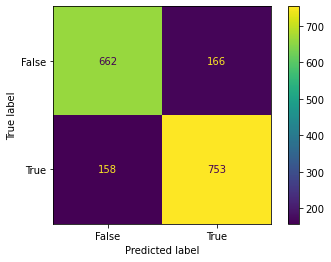

In [49]:
# 컨퓨전 매트릭스
from sklearn.metrics import plot_confusion_matrix
pcm = plot_confusion_matrix(clf, X_val, y_val)

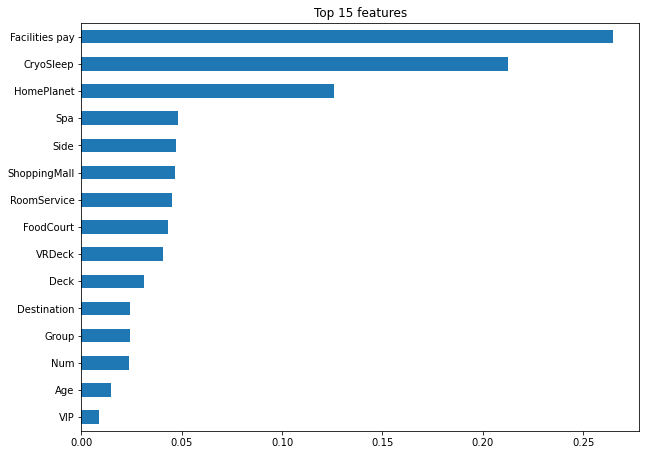

In [92]:
# 특성 중요도 시각화
xgb = clf.best_estimator_.named_steps['xgbclassifier']
importances = pd.Series(xgb.feature_importances_, X_train.columns)

%matplotlib inline

n = 15
plt.figure(figsize = (10, n / 2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [51]:
#!pip install eli5

In [52]:
# 전처리와 모델 분할
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('xgb', XGBClassifier(random_state = 2, n_jobs = -1))
])

In [53]:
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

0.8085106382978723

In [54]:
import eli5
from eli5.sklearn import PermutationImportance

In [55]:
# 순열 중요도
permuter = PermutationImportance(
    pipe.named_steps['xgb'],
    scoring = 'accuracy',
    n_iter = 5,
    random_state = 2
)

X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

permuter.fit(X_val_transformed, y_val);

In [56]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Group             0.000115
VIP               0.000345
Destination       0.007361
HomePlanet        0.013111
Age               0.014146
ShoppingMall      0.015871
Num               0.016216
CryoSleep         0.016791
Deck              0.021162
Side              0.023462
RoomService       0.026797
Spa               0.039103
VRDeck            0.039448
FoodCourt         0.039908
Facilities pay    0.051984
dtype: float64

In [57]:
# 순열 중요도 시각화
eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)

In [58]:
# 순열 중요도가 가장 낮은 Group feature를 drop해서 스코어 측정
X_train_selected = X_train.drop('Group', axis = 1)
X_val_selected = X_val.drop('Group', axis = 1)

In [59]:
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('xgb', XGBClassifier(random_state = 2, n_jobs = -1))
])

pipe.fit(X_train_selected, y_train);

In [60]:
pipe.score(X_val_selected, y_val)

0.8079355951696378

In [98]:
# Spa feature에 대한 PDP
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Spa'

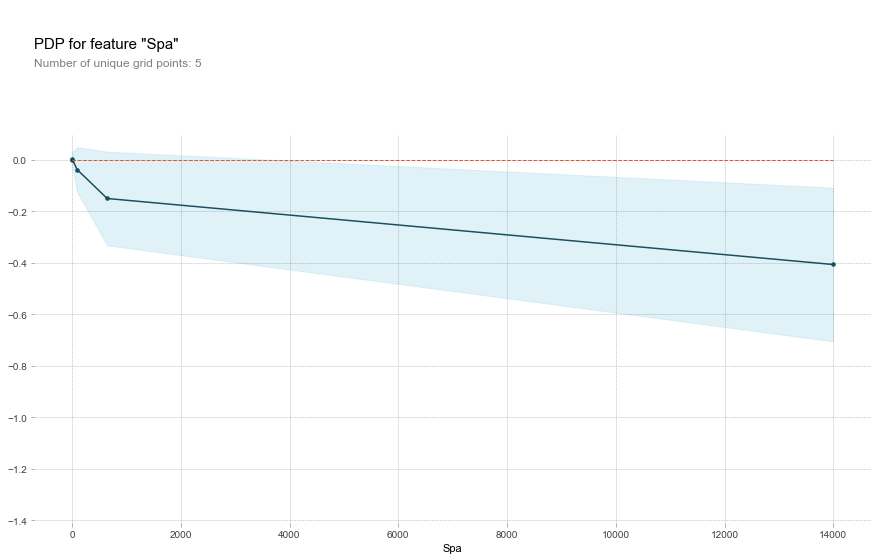

In [99]:
isolated = pdp_isolate(
    model = pipe,
    dataset = X_val_selected,
    feature = feature,
    model_features = X_val_selected.columns,
    grid_type = 'percentile'    
)

pdp_plot(isolated, feature_name = feature);

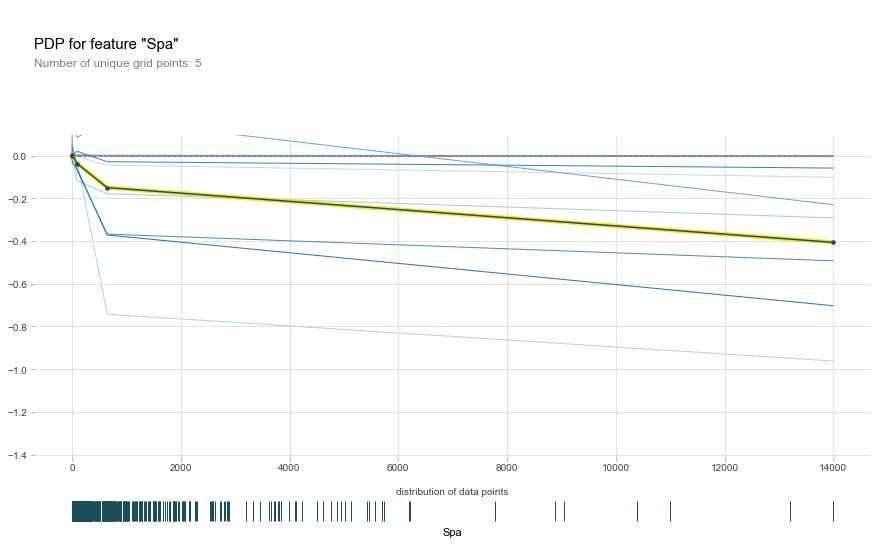

In [100]:
# Spa ICE Curve
pdp_plot(isolated,
        feature_name = feature,
        plot_lines = True,
        frac_to_plot = 10,
        plot_pts_dist = True);

In [64]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

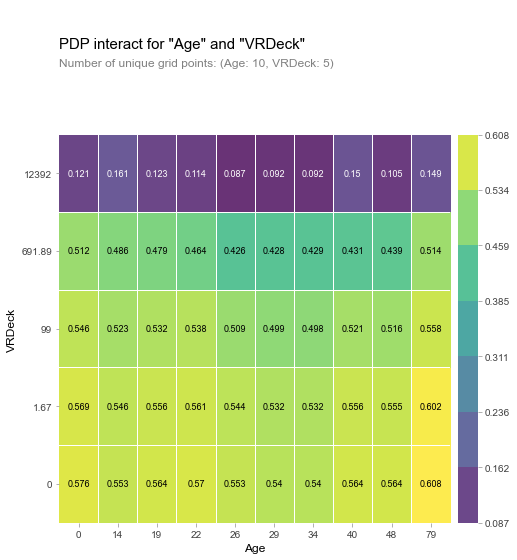

In [65]:
# Age, VRDeck에 대한 PDP
features = ['Age', 'VRDeck']

interaction = pdp_interact(
    model = pipe,
    dataset = X_val_selected,
    model_features = X_val_selected.columns,
    features = features
)

pdp_interact_plot(interaction, plot_type = 'grid',
                 feature_names = features);

In [66]:
import shap

In [68]:
# 연속형 feature들에 대한 shap
model = XGBRegressor(random_state = 2, n_jobs = -1)
model.fit(X_train[continuos], y_train);

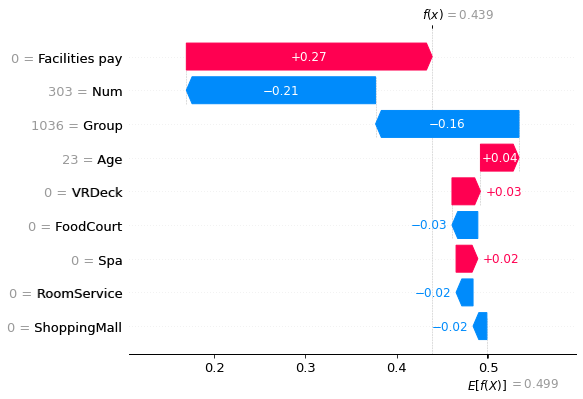

In [69]:
shap.initjs()

explainer = shap.Explainer(model)
shap_values = explainer(X_train[continuos])

shap.plots.waterfall(shap_values[0])

In [70]:
shap.plots.force(shap_values[0])

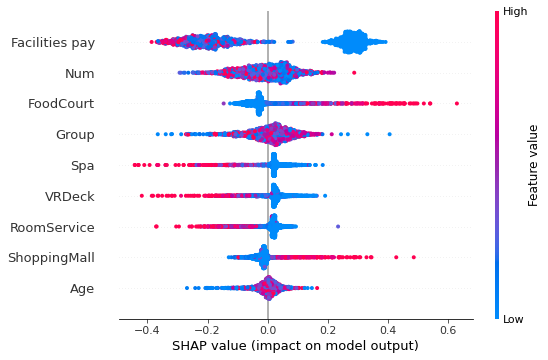

In [72]:
shap_values = explainer.shap_values(X_val[continuos])
shap.summary_plot(shap_values, X_val[continuos])

In [89]:
#to submit kaggle
'''
test1 = pd.read_csv('C:\\Users\\dldud\\Desktop\\urclass\\project2\\spaceship-titanic\\test.csv')
a = test1['PassengerId']

def submit(test):
    y_pred = pd.DataFrame(clf.predict(test))
    y_pred['PassengerId'] = a
    y_pred.set_index('PassengerId', inplace = True)
    y_pred.rename(columns = {0 : 'Transported'}, inplace = True)
    y_pred['Transported'] = y_pred['Transported'].astype('bool')
    y_pred.to_csv('submit.csv')
    
submit(test)
'''